Authors: COLLIN Sasha, MARTIN Paul

The goal of this notebook is to show the reader how we generated the results in our final report, and how to call and use the various methods we coded.

# Imports

In [75]:
!pip install --upgrade scipy

Requirement already up-to-date: scipy in /usr/local/lib/python3.7/dist-packages (1.6.1)


In [76]:
!git clone https://github.com/cosasha97/collapsed-VB-inference-LDA.git

Cloning into 'collapsed-VB-inference-LDA'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 103 (delta 41), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (103/103), 1.44 MiB | 2.82 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import csv
import time
from numba import jit
import random
import scipy.special as sc

In [78]:
try:
  os.chdir("/content/collapsed-VB-inference-LDA")
except:
  print("Staying in ", os.getcwd())

In [79]:
from Gibbs import collapsed_gibbs_sampling_jit
from vb import LDA_VB, log_pba_approx
from collapsed_VB import LDA_collapsed

# Reading Data

In this section, we load the raw data, i.e. the corpus and the vocabulary for the KOS dataset.

In [80]:
vocab = pd.read_csv('./Data/vocab.kos.txt', header = None).rename(columns={0 : 'word'})
corpus = pd.read_csv('./Data/corpus.kos.txt', header=None, sep = ' ', skiprows=3).rename(columns={0: 'document', 1: 'word', 2 : 'count'})
W = 6906
N = 353160
D = 3430

In [81]:
vocab.head()

,word
0,aarp
1,abandon
2,abandoned
3,abandoning
4,abb


In [82]:
corpus.head()

,document,word,count
0,1,61,2
1,1,76,1
2,1,89,1
3,1,211,1
4,1,296,1


# Building document Word Matrix

A document word matrix $M$ is a matrix of size $D \times W$, with $D$ the number of documents and $W$ the number of words. $M[i,j]$ represents the number of time that the word $j$ appears in the document $i$. 

In this section, we build the document-word-matrices used during the training and testing. For our study, we chose a ration of 0.1, which means that 10% of the words are set to a test dataset.

Finally, we have the following relation between the train and test matrices: 
$M = M_{test} + M_{train}$, where $M_{train}$ and  $M_{test}$ respectively designs the document-word-matrices of train and test.

In [83]:
document_word_matrix = np.zeros((D, W))

for i in range(corpus.shape[0]):
  d, w, c  = corpus.iloc[i, :]
  for i in range(c):
    document_word_matrix[d-1, w-1] += 1

In [84]:
# fixing seed
np.random.seed(0)

# document word matrices of train and test
document_word_matrix_train = np.zeros((D, W))
document_word_matrix_test = np.zeros((D, W))

ratio = 0.1
n_doc = 1000
D,W = document_word_matrix.shape
for d in range(D):
  nb_words = document_word_matrix[d,:].sum().astype(int)
  # a given 'ratio' of words are set to the test dataset
  selected_words = random.sample(list(np.arange(nb_words)), int(np.ceil(ratio*nb_words)))
  raw_indexes = np.where(document_word_matrix[d,:])[0] # non-zero elements
  indexes = []
  for k, id in enumerate(raw_indexes):
    for _ in range(int(document_word_matrix[d,id])):
      indexes.append(id)
  for sw in selected_words:
    document_word_matrix_test[d,indexes[sw]] += 1

document_word_matrix_train = document_word_matrix - document_word_matrix_test

# LDA with variational Bayes (VB)

In this section, we apply the VB-LDA algorithm to the dataset. We plot the variational bound, as well as the approximate per-word log-probabilities for the train and test datasets at each iteration of the algorithm

In [85]:
# number of topic
K = 8 
# number of times each document is seen
n_iter_doc = 30
# number of inner iterations
n_iter = 10
# LDA parameters
alpha = 0.1
eta = 0.1

n_doc = 1000
n_word = 10000

t1 = time.time()
VB_bound, log_pba_train_vb, log_pba_test_vb, phi_vb, gamma_vb, lambda_vb = LDA_VB(document_word_matrix_train[:n_doc, :n_word], document_word_matrix_test, n_iter_doc, n_iter, K, alpha, eta)
t2 = time.time()
print('Total time =', t2 - t1)

iter n°0 - iter time = 2.624413013458252 - bound time = 0.5495388507843018 - bound value = -925542.3355183102 - bound_test -177550.59201637498
iter n°1 - iter time = 2.7909061908721924 - bound time = 0.5450499057769775 - bound value = -907153.5326397335 - bound_test -169280.7780007018
iter n°2 - iter time = 2.7467293739318848 - bound time = 0.5394177436828613 - bound value = -891840.5429751504 - bound_test -161845.5045810225
iter n°3 - iter time = 2.7510173320770264 - bound time = 0.5295705795288086 - bound value = -883062.2865782303 - bound_test -155428.33819789672
iter n°4 - iter time = 2.693087339401245 - bound time = 0.5233325958251953 - bound value = -878350.6790468025 - bound_test -149814.27076591138
iter n°5 - iter time = 2.509348154067993 - bound time = 0.5253379344940186 - bound value = -875616.105875025 - bound_test -145822.51288906118
iter n°6 - iter time = 2.0830137729644775 - bound time = 0.5253419876098633 - bound value = -874396.065931554 - bound_test -143681.6546739113


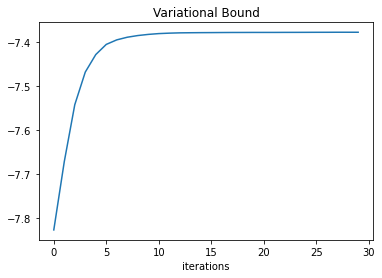

In [86]:
plt.plot(np.array(VB_bound)/np.sum(document_word_matrix_train[:n_doc, :n_word]))
plt.title('Variational Bound');
_ = plt.xlabel('iterations')

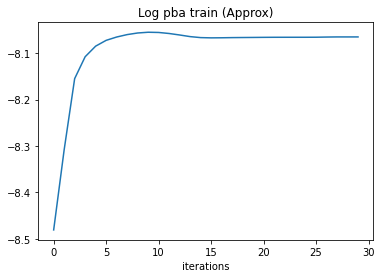

In [ ]:
plt.plot(log_pba_train_vb/np.sum(document_word_matrix_train[:n_doc, :n_word]))
plt.title('Log pba train (Approx)');
_ = plt.xlabel('iterations')

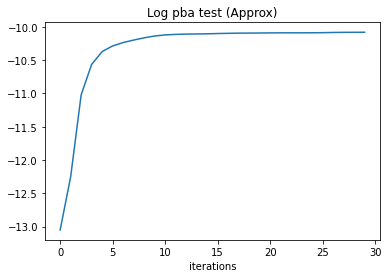

In [ ]:
plt.plot(log_pba_test_vb/np.sum(document_word_matrix_test[:n_doc, :n_word]))
plt.title('Log pba test (Approx)');
_ = plt.xlabel('iterations')

# Collapsed gibbs sampling

In this section, we apply the collapsed gibbs sampling to the dataset. We then plot the per-word log-probabilies at each iteration.

In [ ]:
K = 8

n_iter = 100
alpha = 0.1
eta = 0.1

n_doc = 10000
n_word = 10000

t1 = time.time()
approx_pba, z = collapsed_gibbs_sampling_jit(document_word_matrix_test[:n_doc,:n_word], n_iter, K, alpha, eta)
t2 = time.time()
print('Total time =', t2 - t1)

Total time = 30.159645795822144


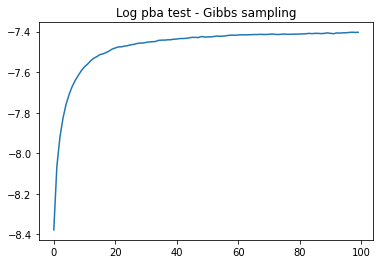

In [ ]:
plt.plot(approx_pba / np.sum(document_word_matrix_test[:n_doc, :n_word]))
plt.title('Log pba test - Gibbs sampling');

# Collapsed Variational Bayesian (CVB) Inference for LDA

In this section, we apply the CVB-LDA algorithm to the dataset. We then plot the approximate per-word log-probabilities for the train and test datasets at each iteration of the algorithm.

In [ ]:
K = 8

n_iter_doc = 30
n_iter = 7
alpha = 0.1
eta = 0.1

n_docs = 100
n_mots = 1000

t1 = time.time()
bound_list_cl, bound_test_cl, phi_cl, gamma_cl, lambda_cl = LDA_collapsed(document_word_matrix_train[:n_docs,:n_mots], document_word_matrix_test[:n_docs,:n_mots], n_iter_doc, n_iter, K, alpha, eta)
t2 = time.time()
print('Total time =', t2 - t1)

iter n°0 - iter time = 0.4264647960662842 - bound time = 0.014839649200439453 - bound value = -11797.949359536933 - bound_test -3686.1271272924328
iter n°1 - iter time = 0.3178267478942871 - bound time = 0.015530586242675781 - bound value = -10416.86030001198 - bound_test -2975.070000623157
iter n°2 - iter time = 0.2621610164642334 - bound time = 0.014504194259643555 - bound value = -10336.781418537339 - bound_test -2875.904358397847
iter n°3 - iter time = 0.24864792823791504 - bound time = 0.014700174331665039 - bound value = -10299.95632707481 - bound_test -2818.496422274943
iter n°4 - iter time = 0.21620631217956543 - bound time = 0.01499795913696289 - bound value = -10276.125564238559 - bound_test -2783.33958539327
iter n°5 - iter time = 0.21659493446350098 - bound time = 0.014578104019165039 - bound value = -10263.725680790974 - bound_test -2750.6990436035094
iter n°6 - iter time = 0.2070636749267578 - bound time = 0.015722036361694336 - bound value = -10262.704360488777 - bound_t

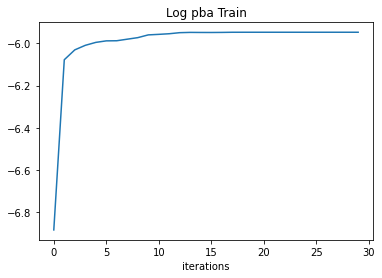

In [ ]:
plt.plot(np.array(bound_list_cl)/np.sum(document_word_matrix_train[:n_docs,:n_mots]))
plt.title('Log pba Train');
_ = plt.xlabel('iterations')

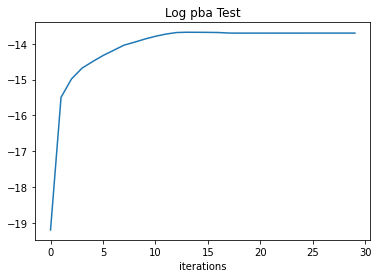

In [ ]:
plt.plot(np.array(bound_test_cl)/np.sum(document_word_matrix_test[:n_docs,:n_mots]))
plt.title('Log pba Test');
_ = plt.xlabel('iterations')

# Final log-proba plots

In this section, we generate the figures used in the final report. As some results are computationally expensive, we computed them once and saved them in the github repository.

In [ ]:
# loading precomputed log-proba curves
test_gibbs = np.load('results/test_Gibbs_log_pba.npy')

test_VB_pba = np.load('results/test_VB_log_pba.npy')
train_VB_pba = np.load('results/train_VB_log_pba.npy')

train_coll = np.load('results/train_Coll_log_pba.npy')
test_coll = np.load('results/test_Coll_log_pba.npy')

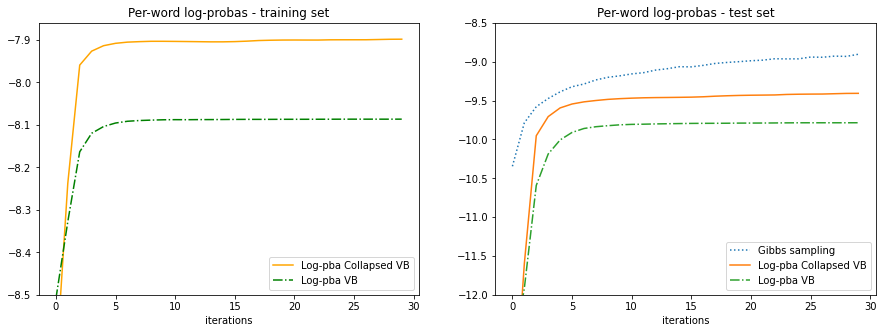

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# training curves
ax[0].plot(train_coll, c='orange', label = 'Log-pba Collapsed VB')
ax[0].plot(train_VB_pba, '-.', c='g', label = 'Log-pba VB')
ax[0].set_xlabel('iterations')
ax[0].set_ylim([-8.5,-7.86])
ax[0].legend()
ax[0].set_title("Per-word log-probas - training set")

# test curves
ax[1].plot(test_gibbs, ':', label='Gibbs sampling')
ax[1].plot(test_coll, label = 'Log-pba Collapsed VB')
ax[1].plot(test_VB_pba, '-.', label = 'Log-pba VB')
ax[1].legend()
ax[1].set_xlabel('iterations')
ax[1].set_title("Per-word log-probas - test set")
_ = ax[1].set_ylim([-12,-8.5])

# Best words per topic

In this part, we retrieve the best words per topic. For each topic, we look at the $n_{max}$ most probable words.

In [9]:
lambda_CVB = np.load('results/lambda_.npy')

In [60]:
def best_words_per_topic(lambda_, vocab, n_max=10, topics=None):
  """
  Compute best words per topic.

  :param lambda: array of size K*W, (unnormalized) distributions of topics over words
  :param n_max: int, number of best words to show
  """
  # nb of topics
  K = lambda_.shape[0]

  # compute best_words
  best_idx = np.argsort(lambda_, axis = 1)[:, -n_max:]
  Best_word = []

  for k in range(K):
    best_word_topic = []
    for w in range(n_max):
      best_word_topic.append(vocab[best_idx[k, w]])
    Best_word.append(best_word_topic)

  # print best_words
  if topics is None:
    # print results for all topics
    topics = np.arange(K)
  
  for topic in topics:
    print("=== Topic {} ===".format(topic+1))
    str_bw = ''
    for k, word in enumerate(Best_word[topic]):
      str_bw += Best_word[topic][k]
      str_bw += ', '
    print(str_bw[:-2])

In [87]:
print("-------------- \n classical VB \n-------------- ")
best_words_per_topic(lambda_vb, vocab.to_numpy().squeeze(), 10)

-------------- 
 classical VB 
-------------- 
=== Topic 1 ===
chalabi, terrorist, team, human, article, protests, kids, endspan, results, voting
=== Topic 2 ===
rcalif, lugar, mcgovern, harman, dole, roundup, adviser, ohpres, enterprise, cnnusa
=== Topic 3 ===
campaign, republicans, senate, war, general, poll, house, november, kerry, bush
=== Topic 4 ===
sox, deficit, delays, rogers, confident, schools, holding, interrogation, grassroots, matching
=== Topic 5 ===
perle, orders, bloc, pakistan, mouse, wounded, mice, french, ndp, handover
=== Topic 6 ===
report, account, support, numbers, convention, win, races, john, media, iraq
=== Topic 7 ===
foundations, fishing, heroism, elliott, nyt, liebeck, stella, oceana, mcdonalds, video
=== Topic 8 ===
personal, high, add, reason, men, saddam, attacks, members, early, wont


In [65]:
print("-------------- \n Collapsed VB \n-------------- ")
best_words_per_topic(lambda_CVB, vocab.to_numpy().squeeze(), 10)

-------------- 
 Collapsed VB 
-------------- 
=== Topic 1 ===
cnnusa, mehlman, luntz, china, googlebomb, teresa, bishops, colmes, reynolds, nagourney
=== Topic 2 ===
understood, monetary, motivations, veto, israeli, misterajc, bloomfield, countdown, virginiadem, punkmonk
=== Topic 3 ===
cnnusa, mehlman, luntz, china, googlebomb, teresa, bishops, colmes, reynolds, nagourney
=== Topic 4 ===
cnnusa, mehlman, luntz, china, googlebomb, teresa, bishops, colmes, reynolds, nagourney
=== Topic 5 ===
people, campaign, republicans, war, senate, poll, general, house, kerry, bush
=== Topic 6 ===
watchers, openhttpwwwedwardsforprezcomdailykoshtml, contact, login, powered, voting, sunzoo, electoral, account, november
=== Topic 7 ===
liberation, shia, imam, dry, hospitals, occupy, arrives, palestinians, alhusainy, dearborn
=== Topic 8 ===
cnnusa, mehlman, luntz, china, googlebomb, teresa, bishops, colmes, reynolds, nagourney


# Investigating a new dataset: REUTERS

In this section, we apply the three algorithms (VB, collapsed VB, collapsed Gibbs sampling) to the dataset REUTERS, and then plot the evolution of the per-word log-probabilities for each algorithm.

In [23]:
document_word_matrix_reuters = np.load('Data/Reuters_dataset.npy')
vocab_reuters = np.load('Data/Reuters_vocab.npy')

In [26]:
# VB LDA
K = 10
n_iter_doc = 30
n_iter = 10
alpha = 0.1
eta = 0.1

t1 = time.time()
VB_bound_rt, log_pba_train_vb_rt, log_pba_test_vb_rt, phi_vb_rt, gamma_vb_rt, lambda_vb_rt = LDA_VB(document_word_matrix_reuters, document_word_matrix_reuters, n_iter_doc, n_iter, K, alpha, eta)
t2 = time.time()
print('Total time =', t2 - t1)

iter n°0 - iter time = 1.4542410373687744 - bound time = 0.2551913261413574 - bound value = -654011.4968643391 - bound_test -716838.7760447812
iter n°1 - iter time = 1.5490915775299072 - bound time = 0.24212336540222168 - bound value = -635582.0740703782 - bound_test -697107.8122938904
iter n°2 - iter time = 1.539856195449829 - bound time = 0.23741674423217773 - bound value = -616221.1756741136 - bound_test -680224.0884332503
iter n°3 - iter time = 1.514174461364746 - bound time = 0.23901677131652832 - bound value = -609477.2393656916 - bound_test -674605.1432327377
iter n°4 - iter time = 1.3175990581512451 - bound time = 0.24083304405212402 - bound value = -607473.8365337525 - bound_test -673412.4653125769
iter n°5 - iter time = 1.163259506225586 - bound time = 0.244215726852417 - bound value = -607216.6512964194 - bound_test -673729.5786927572
iter n°6 - iter time = 1.060354471206665 - bound time = 0.24961423873901367 - bound value = -606930.5249776659 - bound_test -673672.3560073755

In [35]:
# CVB LDA
K=10
t1 = time.time()
bound_list_cl_rt, bound_test_cl_rt, phi_cl_rt, gamma_cl_rt, lambda_cl_rt = LDA_collapsed(document_word_matrix_reuters, document_word_matrix_reuters, n_iter_doc, n_iter, K, alpha, eta)
t2 = time.time()
print('Total time =', t2 - t1)

iter n°0 - iter time = 91.51463055610657 - bound time = 0.1402721405029297 - bound value = -724245.2940705352 - bound_test -724245.2940705352
iter n°1 - iter time = 85.18184208869934 - bound time = 0.12950444221496582 - bound value = -670497.9245301102 - bound_test -670497.9245301102
iter n°2 - iter time = 65.21016907691956 - bound time = 0.15796685218811035 - bound value = -664715.0810358662 - bound_test -664715.0810358662
iter n°3 - iter time = 47.301267862319946 - bound time = 0.13122129440307617 - bound value = -664400.6142542495 - bound_test -664400.6142542495
iter n°4 - iter time = 41.30910062789917 - bound time = 0.14150667190551758 - bound value = -664509.5205196798 - bound_test -664509.5205196798
iter n°5 - iter time = 36.01894736289978 - bound time = 0.12830662727355957 - bound value = -664646.5027731231 - bound_test -664646.5027731231
iter n°6 - iter time = 31.909552574157715 - bound time = 0.13268470764160156 - bound value = -664755.7082988633 - bound_test -664755.708298863

In [54]:
# collapsed gibbs sampling
t1 = time.time()
approx_pba_rt, z_rt = collapsed_gibbs_sampling_jit(document_word_matrix_reuters, n_iter_doc, K, alpha, eta)
t2 = time.time()
print('Total time =', t2 - t1)

Total time = 3.6709446907043457


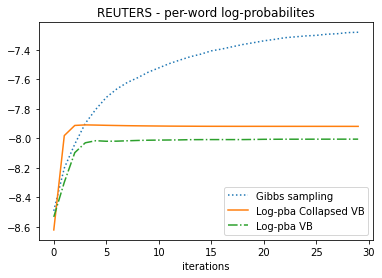

In [69]:
# plots of log-proba evolution
normalization = np.sum(document_word_matrix_reuters)
plt.plot(approx_pba_rt/normalization, ':', label='Gibbs sampling')
plt.plot(bound_list_cl_rt/normalization, label = 'Log-pba Collapsed VB')
plt.plot(log_pba_train_vb_rt/normalization, '-.', label = 'Log-pba VB')
plt.legend()
plt.xlabel('iterations')
_ = plt.title("REUTERS - per-word log-probabilites")

In [62]:
# retrieve best words
print("-------------- \n classical VB \n-------------- ")
best_words_per_topic(lambda_vb_rt, vocab_reuters, n_max=10, topics=None)

-------------- 
 classical VB 
-------------- 
=== Topic 1 ===
rituals, harris, hot, minor, banned, parades, closely, fiestas, portman, goat
=== Topic 2 ===
bulletin, pilgrims, abdominal, quickly, neurological, surgeon, trembling, africa, poles, gemelli
=== Topic 3 ===
year, world, told, first, last, mother, people, years, pope, church
=== Topic 4 ===
gustaf, board, swedish, farrakhan, sweden, saw, east, chernomyrdin, bertil, beach
=== Topic 5 ===
spanish, deny, telling, channel, barcelona, sofia, belgian, elder, atlanta, cristina
=== Topic 6 ===
scotland, board, erupted, roderick, flow, concrete, sean, dancing, lahar, whibley
=== Topic 7 ===
leading, cathedral, october, birthday, east, court, took, private, statement, group
=== Topic 8 ===
around, paris, left, royal, prince, n't, made, against, since, u.s
=== Topic 9 ===
shed, direction, alzheimer, nancy, wehrmacht, jamaica, mirecki, royals, csu, credit
=== Topic 10 ===
full-page, massachusetts, dior, kerry, cerpa, tsongas, liver, lei

In [64]:
print("-------------- \n Collapsed VB \n-------------- ")
best_words_per_topic(lambda_cl_rt, vocab_reuters, n_max=10, topics=None)

-------------- 
 Collapsed VB 
-------------- 
=== Topic 1 ===
10th, turks, ottoman, armenians, slavs, theodoridis, athos, venizelos, byzantine, salonika
=== Topic 2 ===
daly, pocahontas, redwood, stewart, colston, estrada, cornwell, hwang, cavallo, brennan
=== Topic 3 ===
year, world, told, first, last, mother, people, years, pope, church
=== Topic 4 ===
daly, pocahontas, redwood, stewart, colston, estrada, cornwell, hwang, cavallo, brennan
=== Topic 5 ===
2.3, second-largest, inoperable, pilla, chemotherapy, pancreatic, liver, chicago, archdiocese, bernardin
=== Topic 6 ===
crucitti, doctors, appendix, russia, kremlin, russian, surgery, operation, pope, yeltsin
=== Topic 7 ===
scholars, geller, pelvis, memphis, graceland, chadwick, bethlehem, fans, presley, elvis
=== Topic 8 ===
hao, thich, thien, buddhism, hanoi, monks, temple, dent, vietnam, buddhist
=== Topic 9 ===
daly, pocahontas, redwood, stewart, colston, estrada, cornwell, hwang, cavallo, brennan
=== Topic 10 ===
daly, pocaho